# VISUALISE RESULTS

### Import relevant packages

In [1]:
import pandas as pd
import os
import copy
import matplotlib.pyplot as plt
import seaborn as sns
import re
import glob
import numpy as np
import random

from sklearn.metrics import precision_recall_fscore_support, f1_score

sns.set(font_scale=1.3)
sns.set_style()

### Load results across test sets
Each "result" is a csv of gold labels and model predictions.
The results are stored in a nested dict: testset -> model -> train_size -> random_state ("rs1" to "rs10" for the 10 random seeds, plus "al" for active learning and "full" for models trained on all available training data)

In [2]:
results_dict = dict()

SIZES = [0,10,20,30,40,50,100,200,300,400,500,1000,2000]
RANDOM_STATES = ["rs"+str(i) for i in range(1,11)]+["al", "full"]

for testset in sorted(os.listdir("./results")):
    if "a[ifsjdg[ij" not in testset:
        print(testset)
        results_dict[testset] = dict()
        
        for model in pd.unique([m.split("_")[0] for m in os.listdir(f"./results/{testset}")]):
            if "ipynb" not in model:
                print("  ", model)
                results_dict[testset][model] = dict()
                
                for size in sorted(pd.unique([int(i.split("_")[-2]) for i in glob.glob(f"./results/{testset}/{model}*.csv")])):
                    results_dict[testset][model][size] = dict()
                    for random_state in sorted(pd.unique([i.split("_")[-1].rstrip(".csv") for i in glob.glob(f"./results/{testset}/{model}_*_*_{size}_*.csv")])):
                        for filename in glob.glob(f"./results/{testset}/{model}_*_{size}_{random_state}.csv"):
                            results_dict[testset][model][size][random_state] = pd.read_csv(filename)
                
                # 0-shot xlmt models
                for filename in glob.glob(f"./results/{testset}/{model}*_20000_rs1.csv"):
                    results_dict[testset][model][0] = dict()
                    results_dict[testset][model][0]["rs1"] = pd.read_csv(filename)
                    del results_dict[testset][model][20000]["rs1"] # delete redundant entry

bas19_es_test_2000
   xlmr
   xlmt
   robertuito
for19_pt_test_2000
   xlmr
   bertimbau
   xlmt
hatecheck_ar
   arabert
   xlmt
hatecheck_es
   xlmt
   robertuito
hatecheck_it
   umberto
   xlmt
hatecheck_pt
   bertimbau
   xlmt
ous19_ar_test_1000
   xlmr
   arabert
   xlmt
ous19_fr_test_1500
   xlmr
   camembert
   xlmt
san20_it_test_2000
   xlmt
   umberto
   xlmr


### Compute macro F1 for each model/testset combination

In [3]:
metrics_dict = copy.deepcopy(results_dict)

for testset in metrics_dict:
    print(testset)
    for model in metrics_dict[testset]:
        print(" ", model)
        for size in metrics_dict[testset][model]:
            for random_state in metrics_dict[testset][model][size]:
                metrics_dict[testset][model][size][random_state] = f1_score(metrics_dict[testset][model][size][random_state]["label"],
                                                                            metrics_dict[testset][model][size][random_state]["prediction"],
                                                                            average="macro")

bas19_es_test_2000
  xlmr
  xlmt
  robertuito
for19_pt_test_2000
  xlmr
  bertimbau
  xlmt
hatecheck_ar
  arabert
  xlmt
hatecheck_es
  xlmt
  robertuito
hatecheck_it
  umberto
  xlmt
hatecheck_pt
  bertimbau
  xlmt
ous19_ar_test_1000
  xlmr
  arabert
  xlmt
ous19_fr_test_1500
  xlmr
  camembert
  xlmt
san20_it_test_2000
  xlmt
  umberto
  xlmr


### Create flat df of results for easier plotting

In [4]:
metrics_df = pd.DataFrame(columns=["testset", "model", "train_size", "selection_strat", "macro_f1"])

for testset in metrics_dict:
    for model in metrics_dict[testset]:
        for size in metrics_dict[testset][model]:
            for selection_strat in metrics_dict[testset][model][size]:
                metrics_df.loc[len(metrics_df)+1] = [testset, model, int(size), selection_strat, metrics_dict[testset][model][size][selection_strat]]
                
metrics_df["selection_strat_category"] = metrics_df.selection_strat.apply(lambda x: "active learning" if x=="al" else ("full" if x=="full" else "random"))

### Average macro F1 across random seeds across models for each testset

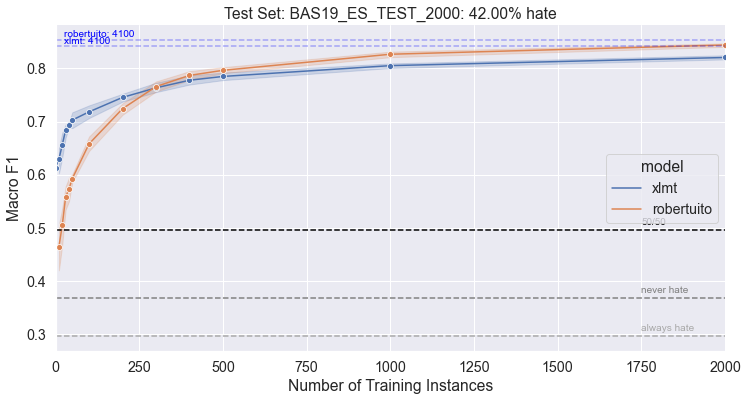

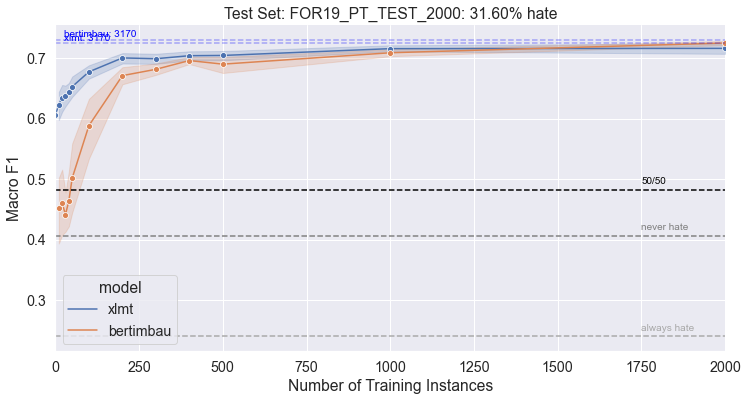

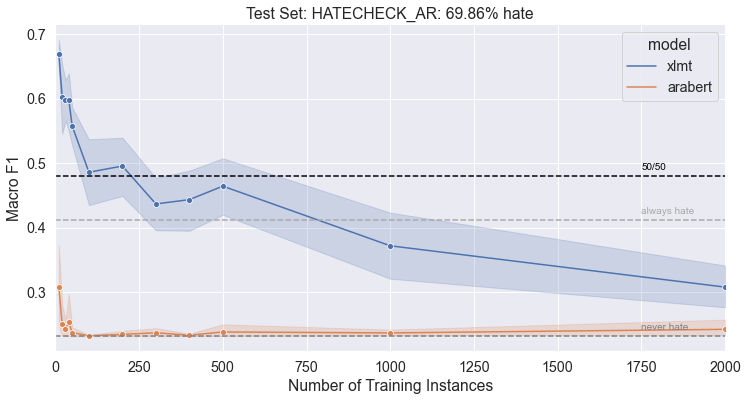

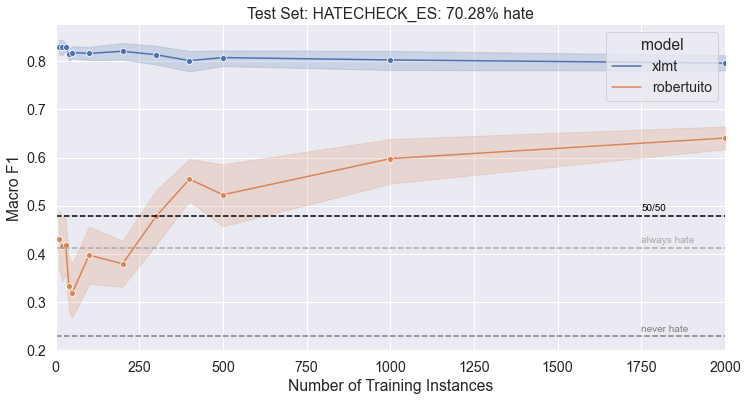

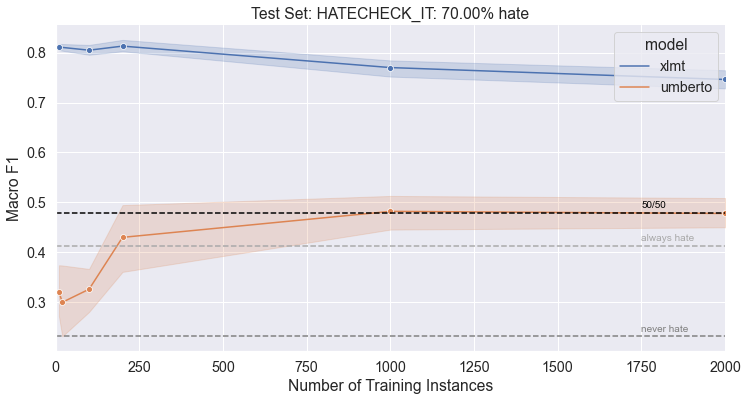

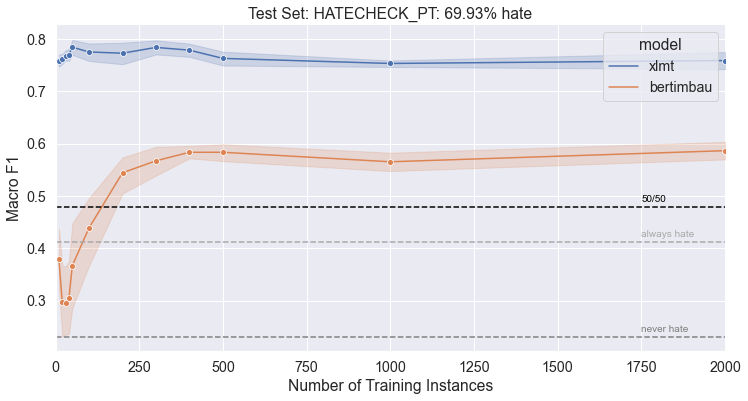

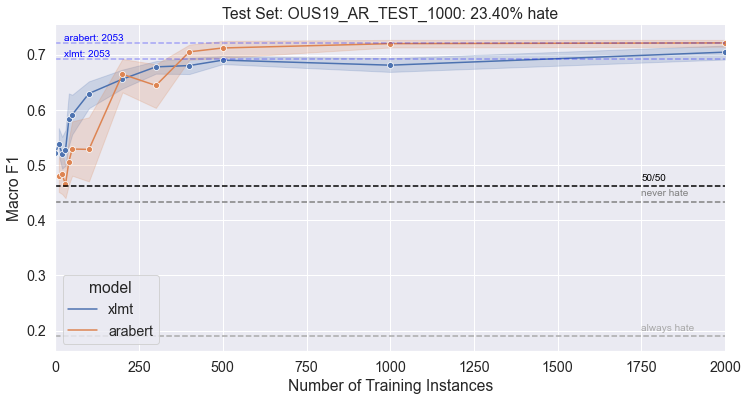

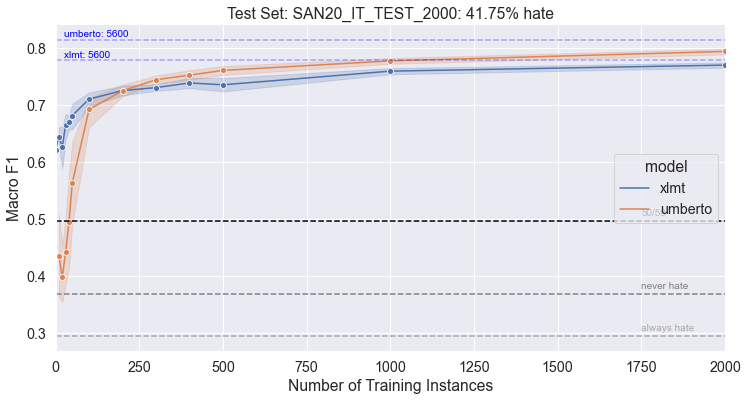

In [5]:
BASELINES = ["always hate", "never hate", "50/50"]
RESULTS_ON_FULL_DATA = True

for target_testset in sorted([t for t in metrics_dict.keys() if "fr" not in t]):

    f = plt.figure(figsize=(12,6))
    
    # Just random samples
    plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="random") & (metrics_df.model!="xlmr")].sort_values(["model"], ascending=False)
    p = sns.lineplot(x="train_size", y="macro_f1", hue="model", data = plot_df, estimator="mean", marker="o", ci=95)
    
    # With AL samples
    #plot_df = metrics_df[(metrics_df.testset==target_testset) & (metrics_df.model!="xlmt")].sort_values(["model","sample"], ascending=False)
    #p = sns.lineplot(x="train_size", y="macro_f1", hue="model", style="sample", data = plot_df, estimator="mean", marker="o", ci=95)
    
    
    # Model performance on full data: 
    if RESULTS_ON_FULL_DATA:
        for _, row in metrics_df[(metrics_df.testset==target_testset) & (metrics_df.selection_strat_category=="full")].sort_values(["model"]).iterrows():
            p.axhline(row.macro_f1, color="blue", linestyle="--", alpha=0.3)
            p.annotate(f"{row.model}: {row.train_size}", xy= (1750,row.macro_f1),  xytext=(25,row.macro_f1+0.005), color = "blue")
    
    
    # Baseline: always hate
    if "always hate" in BASELINES:
        always_hate = f1_score(results_dict[target_testset]['xlmt'][10]['rs1']["label"],
                               len(results_dict[target_testset]['xlmt'][10]['rs1'])*[1],
                               average="macro")
        p.axhline(always_hate, color="darkgrey", linestyle="--")
        p.annotate('always hate', xy= (1750,always_hate),  xytext=(1750,always_hate+0.01), color = "darkgrey")
    
    
    # Baseline: never hate
    if "never hate" in BASELINES:
        never_hate = f1_score(results_dict[target_testset]['xlmt'][10]['rs1']["label"],
                              len(results_dict[target_testset]['xlmt'][10]['rs1'])*[0],
                              average="macro")
        p.axhline(never_hate, color="grey", linestyle="--")
        p.annotate('never hate', xy= (1750,never_hate),  xytext=(1750,never_hate+0.01), color="grey")
    
    
    # Baseline: 50/50 hate/nothate
    if "50/50" in BASELINES:
        equal_prob = list()
        for i in range(1000): # approximate estimated value by repeated sampling
            equal_prob += [f1_score(results_dict[target_testset]['xlmt'][10]['rs1']["label"],
                                    [round(random.uniform(0, 1)) for i in range(len(results_dict[target_testset]['xlmt'][10]['rs1']))],
                                    average="macro")]
        equal_prob = sum(equal_prob)/len(equal_prob)
        p.axhline(equal_prob, color="black", linestyle="--")
        p.annotate('50/50', xy= (1750,equal_prob),  xytext=(1750,equal_prob+0.01), color="black")
    
    # Plot formatting
    p.set_title(f"Test Set: {target_testset.upper()}: {results_dict[target_testset]['xlmt'][10]['rs1'].label.mean():.2%} hate")
    p.set_xlabel("Number of Training Instances")
    p.set_ylabel("Macro F1")
    p.set_xlim(0,2000)
    sns.despine()
    plt.show()